## Load the merged dataset

In [ ]:
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Where this notebook lives
NOTEBOOK_DIR = Path.cwd()

# Path to processed data
DATA_PROCESSED = (NOTEBOOK_DIR / "../data/processed").resolve()

# Load the cleaned/merged dataset
df = pd.read_csv(DATA_PROCESSED / "telco_churn_master.csv", keep_default_na=False)

print("Dataset loaded. Shape:", df.shape)
df.head()

Dataset loaded. Shape: (7043, 48)


,Customer ID,Gender,Age,Under 30,Senior Citizen,Married,Dependents,Number of Dependents,City,Zip Code,...,Total Revenue,Satisfaction Score,Customer Status,Churn Label,Churn Value,Churn Score,CLTV,Churn Category,Churn Reason,Population
0,8779-QRDMV,Male,78,No,Yes,No,No,0,Los Angeles,90022,...,59.65,3,Churned,Yes,1,91,5433,Competitor,Competitor offered more data,68701
1,7495-OOKFY,Female,74,No,Yes,Yes,Yes,1,Los Angeles,90063,...,1024.10,3,Churned,Yes,1,69,5302,Competitor,Competitor made better offer,55668
2,1658-BYGOY,Male,71,No,Yes,No,Yes,3,Los Angeles,90065,...,1910.88,2,Churned,Yes,1,81,3179,Competitor,Competitor made better offer,47534
3,4598-XLKNJ,Female,78,No,Yes,Yes,Yes,1,Inglewood,90303,...,2995.07,2,Churned,Yes,1,88,5337,Dissatisfaction,Limited range of services,27778
4,4846-WHAFZ,Female,80,No,Yes,Yes,Yes,1,Whittier,90602,...,3102.36,2,Churned,Yes,1,67,2793,Price,Extra data charges,26265


## Now we take a look at basic info about the dataset

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 48 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Customer ID                        7043 non-null   object 
 1   Gender                             7043 non-null   object 
 2   Age                                7043 non-null   int64  
 3   Under 30                           7043 non-null   object 
 4   Senior Citizen                     7043 non-null   object 
 5   Married                            7043 non-null   object 
 6   Dependents                         7043 non-null   object 
 7   Number of Dependents               7043 non-null   int64  
 8   City                               7043 non-null   object 
 9   Zip Code                           7043 non-null   int64  
 10  Latitude                           7043 non-null   float64
 11  Longitude                          7043 non-null   float

We can see the loaded data looks good, and there is no missing values.

### Now we compute the overall churn rate to understand how many people abandon the services.

In [3]:
df["Churn Value"].value_counts(normalize=True)

Churn Value
0    0.73463
1    0.26537
Name: proportion, dtype: float64

Around 27% of customers in the dataset have churned.

### Now we create a helper function for churn rate by any feature

To understand which customer groups are most likely to churn, we calculate the churn rate for each category of a selected feature. By grouping customers and taking the average churn value (0 = stayed, 1 = left), we can quickly see which segments have the highest churn risk. This helps highlight key drivers of churn and guides where to focus further analysis.

In [4]:
def churn_rate_by(column):
    """
    Compute and display churn rate for each category in a given column.
    Example: churn_rate_by("Contract")
    """
    return (
        df.groupby(column)["Churn Value"]
        .mean()
        .sort_values(ascending=False)
        .to_frame("Churn Rate")
    )

We will now analyse each variable to assess how it relates to customer churn and to determine which features are truly relevant for explaining or predicting whether a customer leaves or stays.

### 1. Gender

In [9]:
churn_rate_by("Gender")

,Churn Rate
Gender,
Female,0.269209
Male,0.261603


- Female: 26.9% churn
- Male: 26.2% churn

-> Gender has almost no impact on churn.

Any difference is too small to be meaningful.

**Conclusion**: Gender is not a useful predictor and should not be targeted by retention strategy.

### 2. Age

In [18]:
df["Age Group"] = pd.cut(
    df["Age"],
    bins=[0, 20, 30, 40, 50, 60, 110],
    labels=["<20", "20–29", "30–39", "40–49", "50–59", "60+"]
)

churn_rate_by("Age Group")

/var/folders/1g/3vmbpwm93l9f3zvj2lq_l3cr0000gp/T/ipykernel_48274/4007869599.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(column)["Churn Value"]


,Churn Rate
Age Group,
60+,0.364621
50–59,0.246805
40–49,0.235518
30–39,0.235248
20–29,0.230588
<20,0.188976


- <20: 18.9% churn
- 20–29: 23.1% churn
- 30–39: 23.5% churn
- 40–49: 23.6% churn
- 50–59: 24.7% churn
- 60+: 36.5% churn

-> Churn increases steadily with age, with the 60+ group showing a notably higher churn rate.

Any difference between the groups below 60 is relatively small, but the jump in the 60+ segment is meaningful.

**Conclusion**: Age is a useful predictor of churn, particularly the 60+ segment, which should be prioritised in retention strategies.

### 3. Senior Citizen

In [19]:
churn_rate_by("Senior Citizen")


,Churn Rate
Senior Citizen,
Yes,0.416813
No,0.236062


- Senior Citizens: 41.7% churn
- Non–Senior Citizens: 23.6% churn

-> This confirms the previous insights. Senior citizens churn at a much higher rate than younger customers, being almost double the churn observed in the non-senior segment.

The difference is large and meaningful, indicating that older customers are significantly more likely to leave the service.

**Conclusion**: Senior Citizen status is a strong predictor of churn. This segment should be a priority for retention efforts, particularly around simplifying plans, improving support, and addressing potential service or pricing concerns.

### 4. Married

In [20]:
churn_rate_by("Married")

,Churn Rate
Married,
No,0.329580
Yes,0.196649


- Not Married: 32.96% churn
- Married: 19.66% churn

-> Married customers churn far less than non-married customers — a meaningful gap of more than 13 percentage points.

**Conclusion**: Marital status is a useful predictor of churn. Married customers are more stable, likely due to shared plans or household dependencies.

### 5. Dependents 

In [21]:
churn_rate_by("Dependents")

,Churn Rate
Dependents,
No,0.325517
Yes,0.065151


- No Dependents: 32.55% churn
- With Dependents: 6.52% churn

-> Having dependents is strongly associated with lower churn, with a very large difference between households with dependents and those without.

**Conclusion**: Dependents is a highly predictive churn variable. Customers with dependents are significantly more loyal and should be considered a low-risk segment.

### 6. Number of Dependents

In [22]:
churn_rate_by("Number of Dependents")

,Churn Rate
Number of Dependents,
7,0.500000
6,0.333333
0,0.325517
5,0.200000
4,0.111111
1,0.068716
2,0.062147
3,0.058027
8,0.000000


- 0 dependents: 32.55% churn
- 1–3 dependents: ~6–7% churn
- 4–7 dependents: low and unstable due to very small sample size
- 8–9 dependents: 0% churn (tiny sample)

-> The key insight mirrors the binary variable:
The jump is between 0 dependents vs. any dependents.
Differences beyond 1, 2, or 3 dependents reflect low sample noise, not meaningful patterns.

**Conclusion**: “Number of Dependents” does not provide additional useful insight beyond the simple Yes/No dependents variable. The binary version is more reliable and easier to interpret.

### 7. City

In [26]:
city_counts = df["City"].value_counts()
large_cities = city_counts[city_counts > 100].index   # threshold to avoid noise

churn_rate_by("City").loc[large_cities]


,Churn Rate
City,
Los Angeles,0.266212
San Diego,0.649123
San Jose,0.258929
Sacramento,0.240741
San Francisco,0.298077


- San Diego: 64.9% churn
- San Francisco: 29.8% churn
- Los Angeles: 26.6% churn
- San Jose: 25.9% churn
- Sacramento: 24.1% churn

-> Among large cities (100+ customers), San Diego stands out with a significantly higher churn rate, more than double the levels seen in other major cities.

This spike may indicate localised issues (network performance, competitor presence, service quality, or pricing differences), but needs further validation. All other large cities show churn rates in the 24–30% range, which aligns with the overall average.

**Conclusion**: City-level churn is informative when focusing on locations with sufficient sample size. San Diego is an outlier and may warrant targeted investigation, but geography overall should be treated as a secondary churn driver.

### 8. Referred a Friend

In [27]:
churn_rate_by("Referred a Friend")

,Churn Rate
Referred a Friend,
No,0.325831
Yes,0.193669


- Did not refer a friend: 32.6% churn
- Referred a friend: 19.4% churn

-> Customers who have referred others churn significantly less, showing a clear link between advocacy and retention.

**Conclusion**: Referrals are a strong behavioural indicator of loyalty. Customers who refer friends are much less likely to churn and represent a valuable lower risk segment.

### 9. Number of Referrals

In [28]:
churn_rate_by("Number of Referrals")

,Churn Rate
Number of Referrals,
1,0.466851
0,0.325831
3,0.125490
2,0.110169
5,0.079545
4,0.076271
6,0.036199
7,0.024194
9,0.016807


- 0 referrals: 32.6% churn
- 1 referral: 46.7% churn
- 2–3 referrals: 11–12% churn
- 4–7 referrals: 2–8% churn
- 8+ referrals: ~0% churn

-> Churn decreases sharply as the number of referrals increases, with customers who refer multiple friends showing significantly lower churn. Groups with 8–10 referrals have near-zero churn.

**Conclusion**: Number of referrals reinforces the same insight: the more someone refers, the lower their churn risk.

### 10. Tenure in Months

In [29]:
df["Tenure Group"] = pd.cut(
    df["Tenure in Months"],
    bins=[0, 6, 12, 24, 48, 72, 100],
    labels=["0–6", "7–12", "13–24", "25–48", "49–72", "72+"]
)

churn_rate_by("Tenure Group")

/var/folders/1g/3vmbpwm93l9f3zvj2lq_l3cr0000gp/T/ipykernel_48274/4007869599.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(column)["Churn Value"]


,Churn Rate
Tenure Group,
0–6,0.533333
7–12,0.353352
13–24,0.287109
25–48,0.203890
49–72,0.095132
72+,NaN


/var/folders/1g/3vmbpwm93l9f3zvj2lq_l3cr0000gp/T/ipykernel_48274/4007869599.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(column)["Churn Value"]


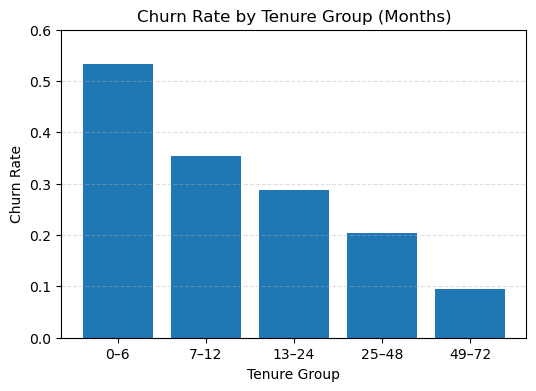

In [81]:
tenure_churn = churn_rate_by("Tenure Group")

plt.figure(figsize=(6,4))
plt.bar(tenure_churn.index.astype(str), tenure_churn["Churn Rate"])
plt.title("Churn Rate by Tenure Group (Months)")
plt.ylabel("Churn Rate")
plt.xlabel("Tenure Group")
plt.ylim(0, 0.6)
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.show()

- 0–6 months: 53.3% churn
- 7–12 months: 35.3% churn
- 13–24 months: 28.7% churn
- 25–48 months: 20.4% churn
- 49–72 months: 9.5% churn
- 72+ months: N/A (very small or no customers in this bin)

-> Tenure shows a classic telecom churn pattern: customers in their first months have the highest churn, and churn decreases steadily as tenure grows.

**Conclusion**: Tenure is one of the strongest predictors of churn. Early lifecycle customers (especially within the first 6 months) are at the highest risk and should be a priority for onboarding and retention efforts.

### 11. Offer

In [31]:
churn_rate_by("Offer")

,Churn Rate
Offer,
Offer E,0.529193
No Offer,0.271086
Offer D,0.267442
Offer C,0.228916
Offer B,0.122573
Offer A,0.067308


- Offer E: 52.9% churn
- No Offer: 27.1% churn
- Offer D: 26.7% churn
- Offer C: 22.9% churn
- Offer B: 12.3% churn
- Offer A: 6.7% churn

-> Churn varies strongly by offer type. Customers on Offer E show extremely high churn, while those on Offer A and Offer B have the lowest churn rates.

**Conclusion**: Offer type is a strong predictor of churn. Certain promotions (e.g., Offer E) are associated with substantially higher churn and may require targeted retention actions or reassessment of the offer structure.

### 12. Phone Service

In [32]:
churn_rate_by("Phone Service")

,Churn Rate
Phone Service,
Yes,0.267096
No,0.249267


- Phone Service = Yes: 26.7% churn
- Phone Service = No: 24.9% churn

-> Churn is slightly higher among customers who have phone service, but the difference is small.

**Conclusion**: Phone service has limited impact on churn and is not a strong driver of customer exit decisions.

### 13. Avg Monthly Long Distance Charges

In [33]:
df["LD Charge Group"] = pd.qcut(df["Avg Monthly Long Distance Charges"], q=5)
churn_rate_by("LD Charge Group")

/var/folders/1g/3vmbpwm93l9f3zvj2lq_l3cr0000gp/T/ipykernel_48274/4007869599.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(column)["Churn Value"]


,Churn Rate
LD Charge Group,
"(39.066, 49.99]",0.272534
"(6.344, 17.228]",0.267756
"(17.228, 28.304]",0.267566
"(28.304, 39.066]",0.262074
"(-0.001, 6.344]",0.256920


- $39.1–50.0: 27.3% churn
- $6.34–17.23: 26.8% churn
- $17.23–28.30: 26.8% churn
- $28.30–39.07: 26.2% churn
- $0.00–6.34: 25.7% churn

-> Churn is relatively stable across all levels of long-distance charges, with only minor variation between groups.

**Conclusion**: Long-distance usage does not meaningfully influence churn. This variable offers limited predictive value.

### 14. Multiple Lines

In [34]:
churn_rate_by("Multiple Lines")

,Churn Rate
Multiple Lines,
Yes,0.286099
No,0.250246


- Multiple Lines = Yes: 28.6% churn
- Multiple Lines = No: 25.0% churn

-> Customers with multiple lines churn slightly more, but the difference is small.

**Conclusion**: Multiple lines has limited impact on churn and does not strongly differentiate customer behaviour.

### 15. Internet Service

In [35]:
churn_rate_by("Internet Service")

,Churn Rate
Internet Service,
Yes,0.318289
No,0.074050


- Internet Service = Yes: 31.8% churn
- Internet Service = No: 7.4% churn

-> Customers with internet service churn at far higher rates, suggesting that internet products face stronger competitive pressure or service-related issues.

**Conclusion**: Internet service is a major churn driver. Customers without internet service are far less likely to leave.

### 16. Internet Type

In [36]:
churn_rate_by("Internet Type")

,Churn Rate
Internet Type,
Fiber Optic,0.407249
Cable,0.256627
DSL,0.185835
None,0.074050


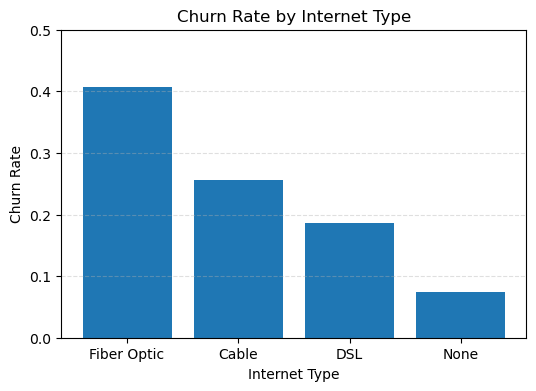

In [83]:
internet_type_churn = churn_rate_by("Internet Type")

plt.figure(figsize=(6,4))
plt.bar(internet_type_churn.index, internet_type_churn["Churn Rate"])
plt.title("Churn Rate by Internet Type")
plt.ylabel("Churn Rate")
plt.xlabel("Internet Type")
plt.ylim(0, 0.5)
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.show()

- Fiber Optic: 40.7% churn
- Cable: 25.7% churn
- DSL: 18.6% churn
- None: 7.4% churn

-> Fiber customers show the highest churn, while cable and DSL customers churn at lower levels. Customers without internet service have the lowest churn.

**Conclusion**: Internet type is a strong predictor of churn. Fiber optic customers are significantly more likely to churn and may require focused retention interventions.

### 17. Avg Monthly GB Download

<Axes: >

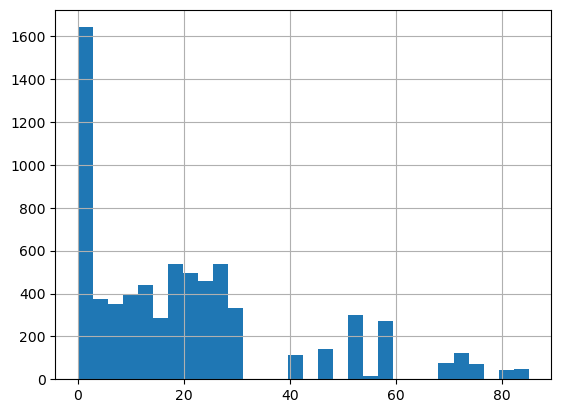

In [38]:
df["Avg Monthly GB Download"].describe()
df["Avg Monthly GB Download"].hist(bins=30)

In [39]:
df["GB Group"] = pd.cut(
    df["Avg Monthly GB Download"],
    bins=[0, 5, 25, 50, 75, df["Avg Monthly GB Download"].max()],
    labels=["0–5", "6–25", "26–50", "51–75", "75+"],
    include_lowest=True
)

churn_rate_by("GB Group")

/var/folders/1g/3vmbpwm93l9f3zvj2lq_l3cr0000gp/T/ipykernel_48274/4007869599.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(column)["Churn Value"]


,Churn Rate
GB Group,
6–25,0.329277
26–50,0.328877
51–75,0.239049
75+,0.228188
0–5,0.149380


- 0–5 GB: 14.9% churn
- 6–25 GB: 32.9% churn
- 26–50 GB: 32.9% churn
- 51–75 GB: 23.9% churn
- 75+ GB: 22.8% churn

-> Very low-usage customers (0–5 GB) have far lower churn, while moderate users (6–50 GB) show the highest churn rates. Heavy users churn less than mid-range users.

**Conclusion**: Usage intensity influences churn. Light users are more likely to stay, while moderate users exhibit the highest churn levels. Extremely heavy users are somewhat more stable but still churn at elevated levels.

### 18. Online Security

In [40]:
churn_rate_by("Online Security")

,Churn Rate
Online Security,
No,0.313296
Yes,0.146112


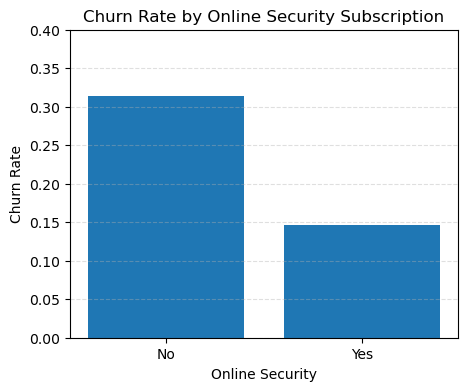

In [84]:
security_churn = churn_rate_by("Online Security")

plt.figure(figsize=(5,4))
plt.bar(security_churn.index, security_churn["Churn Rate"])
plt.title("Churn Rate by Online Security Subscription")
plt.ylabel("Churn Rate")
plt.xlabel("Online Security")
plt.ylim(0, 0.4)
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.show()

- Online Security = No: 31.3% churn
- Online Security = Yes: 14.6% churn

-> Customers without online security churn at more than double the rate of those who have it.

**Conclusion**: Online security is a strong predictor of churn. Customers who subscribe to this add-on are significantly more loyal.

### 19. Online Backup

In [41]:
churn_rate_by("Online Backup")

,Churn Rate
Online Backup,
No,0.291721
Yes,0.215315


- Online Backup = No: 29.2% churn
- Online Backup = Yes: 21.5% churn

-> Churn is noticeably higher among customers who do not have online backup.

**Conclusion**: Online backup contributes to lower churn. While the effect is weaker than other add-ons, it still meaningfully differentiates customer retention.

### 20. Device Protection Plan

In [42]:
churn_rate_by("Device Protection Plan")

,Churn Rate
Device Protection Plan,
No,0.286518
Yes,0.225021


- Device Protection Plan = No: 28.7% churn
- Device Protection Plan = Yes: 22.5% churn

-> Customers with device protection show lower churn than those without it.

**Conclusion**: Device protection is associated with increased loyalty, though the difference is moderate compared to other add-ons.

### 21. Premium Tech Support

In [43]:
churn_rate_by("Premium Tech Support")

,Churn Rate
Premium Tech Support,
No,0.311862
Yes,0.151663


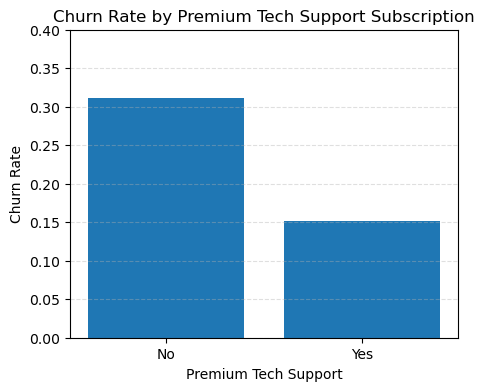

In [85]:
tech_churn = churn_rate_by("Premium Tech Support")

plt.figure(figsize=(5,4))
plt.bar(tech_churn.index, tech_churn["Churn Rate"])
plt.title("Churn Rate by Premium Tech Support Subscription")
plt.ylabel("Churn Rate")
plt.xlabel("Premium Tech Support")
plt.ylim(0, 0.4)
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.show()

- Premium Tech Support = No: 31.2% churn
- Premium Tech Support = Yes: 15.2% churn

-> Churn is much higher among customers without premium tech support.

**Conclusion**: Premium tech support is a strong predictor of churn. Customers purchasing this add-on are far less likely to leave.

### 22. Streaming TV

In [44]:
churn_rate_by("Streaming TV")

,Churn Rate
Streaming TV,
Yes,0.300702
No,0.243312


- Streaming TV = Yes: 30.1% churn
- Streaming TV = No: 24.3% churn

-> Customers who use streaming TV churn at noticeably higher rates.

**Conclusion**: Streaming TV subscribers are more prone to churn. This add-on is not associated with loyalty, unlike other service add-ons.

### 23. Streaming Movies

In [45]:
churn_rate_by("Streaming Movies")

,Churn Rate
Streaming Movies,
Yes,0.299414
No,0.243795


- Streaming Movies = Yes: 29.9% churn
- Streaming Movies = No: 24.4% churn

-> Similar to streaming TV, customers with streaming movie services exhibit higher churn.

**Conclusion**: Streaming movie usage correlates with elevated churn. This feature does not contribute to retention and may indicate a segment with alternative entertainment options or higher price sensitivity.

### 24. Streaming Music

In [46]:
churn_rate_by("Streaming Music")

,Churn Rate
Streaming Music,
Yes,0.292605
No,0.250494


- Streaming Music = Yes: 29.3% churn
- Streaming Music = No: 25.0% churn

-> Churn is higher among streaming music users, though the difference is smaller compared to TV and movies.

**Conclusion**: Streaming music has a modest association with higher churn and is not a strong retention indicator.

### 25. Unlimited Data

In [47]:
churn_rate_by("Unlimited Data")

,Churn Rate
Unlimited Data,
Yes,0.316544
No,0.159704


- Unlimited Data = Yes: 31.7% churn
- Unlimited Data = No: 16.0% churn

-> Customers with unlimited data churn at nearly double the rate of customers without unlimited data.

**Conclusion**: Unlimited data is strongly linked to higher churn. This may reflect a segment of heavier users who are more price-sensitive or more likely to switch for better deals.

**Insight:** Across all four features, a consistent pattern emerges:

- Customers who purchase entertainment or heavy-data products tend to churn more,
- Whereas protective or support features (like security or tech support) reduce churn.

This is an useful insight: usage-based add-ons do NOT prevent churn, but service-based add-ons DO.

### 26. Contract

In [48]:
churn_rate_by("Contract")

,Churn Rate
Contract,
Month-to-Month,0.458449
One Year,0.107097
Two Year,0.025491


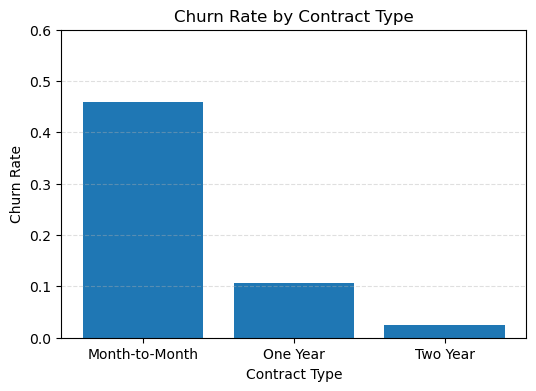

In [ ]:
contract_churn = churn_rate_by("Contract")

plt.figure(figsize=(6,4))
plt.bar(contract_churn.index, contract_churn["Churn Rate"])
plt.title("Churn Rate by Contract Type")
plt.ylabel("Churn Rate")
plt.xlabel("Contract Type")
plt.ylim(0, 0.6)
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.show()

- Month-to-Month: 45.8% churn
- One Year: 10.7% churn
- Two Year: 2.5% churn

-> Month-to-month customers churn at extremely high rates compared to annual contract customers.

**Conclusion**: Contract type is one of the strongest churn predictors. Long-term contracts create significant retention, while month-to-month users are highly churn-prone.

### 27. Paperless Billing

In [49]:
churn_rate_by("Paperless Billing")

,Churn Rate
Paperless Billing,
Yes,0.335651
No,0.163301


- Paperless Billing = Yes: 33.6% churn
- Paperless Billing = No: 16.3% churn

-> Customers with paperless billing churn at double the rate of those who receive physical bills.

**Conclusion**: Paperless billing is associated with much higher churn. This tends to reflect a cluster of digital-only, possibly more price-sensitive customers.

### 28. Payment Method

In [51]:
churn_rate_by("Payment Method")

,Churn Rate
Payment Method,
Mailed Check,0.368831
Bank Withdrawal,0.339985
Credit Card,0.144780


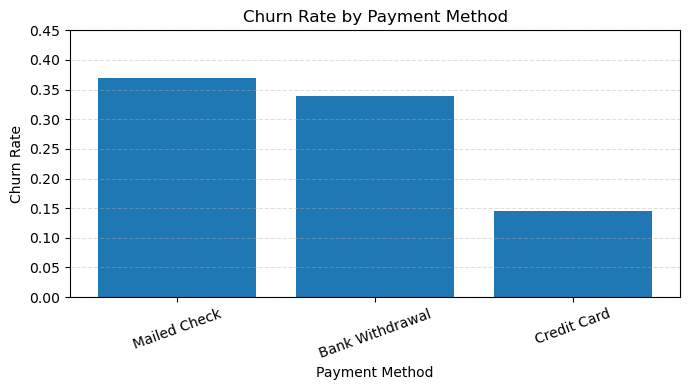

In [86]:
payment_churn = churn_rate_by("Payment Method")

plt.figure(figsize=(7,4))
plt.bar(payment_churn.index, payment_churn["Churn Rate"])
plt.title("Churn Rate by Payment Method")
plt.ylabel("Churn Rate")
plt.xlabel("Payment Method")
plt.ylim(0, 0.45)
plt.xticks(rotation=20)
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

- Mailed Check: 36.9% churn
- Bank Withdrawal: 34.0% churn
- Credit Card: 14.5% churn

-> Customers paying by credit card churn far less than those paying by mailed check or bank withdrawal.

**Conclusion**: Payment method is a relevant churn driver. Credit-card payers are significantly more loyal, whereas mailed-check users are the highest-risk group.

### 29. Monthly Charge

In [53]:
df["Monthly Charge Group"] = pd.qcut(df["Monthly Charge"], q=5)
churn_rate_by("Monthly Charge Group")

/var/folders/1g/3vmbpwm93l9f3zvj2lq_l3cr0000gp/T/ipykernel_48274/4007869599.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(column)["Churn Value"]


,Churn Rate
Monthly Charge Group,
"(79.1, 94.25]",0.361052
"(94.25, 118.75]",0.328125
"(58.83, 79.1]",0.297661
"(25.05, 58.83]",0.249821
"(18.249, 25.05]",0.091549


/var/folders/1g/3vmbpwm93l9f3zvj2lq_l3cr0000gp/T/ipykernel_48274/4007869599.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(column)["Churn Value"]


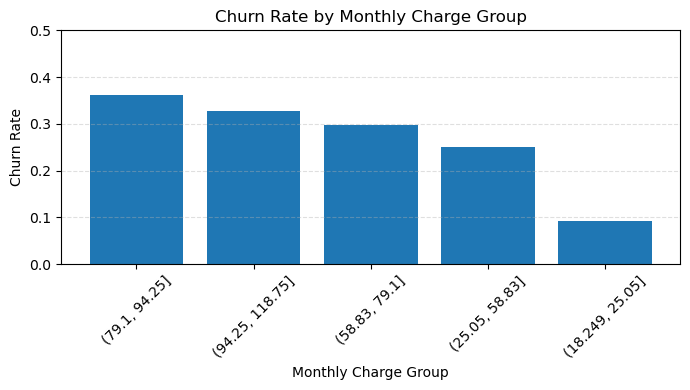

In [82]:
monthly_churn = churn_rate_by("Monthly Charge Group")

plt.figure(figsize=(7,4))
plt.bar(monthly_churn.index.astype(str), monthly_churn["Churn Rate"])
plt.title("Churn Rate by Monthly Charge Group")
plt.ylabel("Churn Rate")
plt.xlabel("Monthly Charge Group")
plt.ylim(0, 0.5)
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

- Highest charges ($79–$118): 33–36% churn
- Mid-range charges ($25–$79): 25–30% churn
- Lowest charges ($18–$25): 9.1% churn

-> Churn increases steadily with higher monthly charges.

**Conclusion**: Monthly charge is a clear predictor of churn. High-spend customers churn much more frequently, likely reflecting price sensitivity among heavy users.

### 30. Total Charges

In [54]:
df["Total Charges Group"] = pd.qcut(df["Total Charges"], q=5)
churn_rate_by("Total Charges Group")

/var/folders/1g/3vmbpwm93l9f3zvj2lq_l3cr0000gp/T/ipykernel_48274/4007869599.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(column)["Churn Value"]


,Churn Rate
Total Charges Group,
"(18.799, 266.68]",0.458481
"(266.68, 939.78]",0.288352
"(2043.71, 4471.44]",0.230114
"(939.78, 2043.71]",0.208659
"(4471.44, 8684.8]",0.141235


In [65]:
df[["Tenure in Months", "Total Charges", "Monthly Charge"]].corr()

,Tenure in Months,Total Charges,Monthly Charge
Tenure in Months,1.000000,0.826074,0.247582
Total Charges,0.826074,1.000000,0.651236
Monthly Charge,0.247582,0.651236,1.000000


- Lowest charges (18–267): 45.8% churn
- Lower-mid charges (266–939): 28.8% churn
- Mid charges (939–2043): 20.9% churn
- Higher charges (2043–4471): 23.0% churn
- Highest charges (4471–8684): 14.1% churn

-> Churn is dramatically higher among customers with the lowest total charges, then decreases steadily as total charges increase.

**Conclusion**: Total Charges is a strong churn indicator, but it mostly reflects customer tenure - low charges correspond to new customers, who churn more, while high-total-charge customers are long-tenure and stable.

### 31. Total Refunds

In [60]:
df["Refund_Flag"] = (df["Total Refunds"] > 0).astype(int)
churn_rate_by("Refund_Flag")

,Churn Rate
Refund_Flag,
0,0.270328
1,0.203810


- No refund: 27.0% churn
- Refund received: 20.4% churn

-> Customers who received at least one refund churn slightly less, although the difference is modest.

**Conclusion**: Refund history most likely has weak predictive power. Receiving a refund may reduce churn somewhat, but the effect is small and not a major driver.

### 32. Total Extra Data Charges

In [62]:
df["Extra_Data_Flag"] = (df["Total Extra Data Charges"] > 0).astype(int)
churn_rate_by("Extra_Data_Flag")

,Churn Rate
Extra_Data_Flag,
1,0.328297
0,0.258116


- Has extra data charges: 32.8% churn
- No extra data charges: 25.8% churn

-> Customers incurring extra data fees churn notably more than those who stay within their allowance.

**Conclusion**: Extra data charges are a meaningful churn risk signal for a small segment of customers, likely due to dissatisfaction with unexpected overage fees.

### 33. Total Long Distance Charges

In [63]:
df["Long Distance Charge Group"] = pd.qcut(
    df["Total Long Distance Charges"],
    q=5
)
churn_rate_by("Long Distance Charge Group")

/var/folders/1g/3vmbpwm93l9f3zvj2lq_l3cr0000gp/T/ipykernel_48274/4007869599.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(column)["Churn Value"]


,Churn Rate
Long Distance Charge Group,
"(-0.001, 40.272]",0.400284
"(40.272, 226.15]",0.381392
"(226.15, 642.624]",0.253371
"(642.624, 1460.376]",0.169744
"(1460.376, 3564.72]",0.122072


In [67]:
df[["Tenure in Months", "Total Long Distance Charges"]].corr()

,Tenure in Months,Total Long Distance Charges
Tenure in Months,1.000000,0.674149
Total Long Distance Charges,0.674149,1.000000


- Lowest LD charges (0–40): 40.0% churn
- Low-mid LD charges (40–226): 38.1% churn
- Mid LD charges (226–642): 25.3% churn
- High LD charges (642–1460): 16.9% churn
- Highest LD charges (1460–3564): 12.2% churn

-> Churn falls consistently as long-distance charges increase.

**Conclusion**: Long-distance charges are a strong churn predictor, but like Total Charges, this reflects tenure and usage intensity — customers with higher accumulated charges are long-term, engaged users who churn less.

### 34. Total Revenue

In [68]:
df["Total Revenue Group"] = pd.qcut(
    df["Total Revenue"],
    q=5,
    duplicates="drop"
)
churn_rate_by("Total Revenue Group")

/var/folders/1g/3vmbpwm93l9f3zvj2lq_l3cr0000gp/T/ipykernel_48274/4007869599.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(column)["Churn Value"]


,Churn Rate
Total Revenue Group,
"(21.358999999999998, 405.88]",0.480483
"(405.88, 1405.708]",0.304688
"(1405.708, 2965.93]",0.214336
"(2965.93, 5773.084]",0.188210
"(5773.084, 11979.34]",0.139106


- Lowest revenue (21–405): 48.0% churn
- Low–mid revenue (405–1405): 30.5% churn
- Mid revenue (1405–2966): 21.4% churn
- High revenue (2966–5773): 18.8% churn
- Highest revenue (5773–11979): 13.9% churn

-> Churn drops steadily as total revenue increases.

**Conclusion**: Total revenue is a strong churn indicator, but mostly because it reflects customer tenure. Low-revenue customers are new and churn frequently, while high-revenue customers are long-tenure and very stable.

### 35. CLTV

In [74]:
df["CLTV Group"] = pd.qcut(df["CLTV"], q=5, duplicates="drop")
churn_rate_by("CLTV Group")

/var/folders/1g/3vmbpwm93l9f3zvj2lq_l3cr0000gp/T/ipykernel_48274/4007869599.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(column)["Churn Value"]


,Churn Rate
CLTV Group,
"(2002.999, 3175.4]",0.349184
"(3175.4, 4194.0]",0.299503
"(4194.0, 4882.2]",0.245739
"(4882.2, 5540.0]",0.225532
"(5540.0, 6500.0]",0.206823


- Lowest CLTV (2003–3175): 34.9% churn
- Low–mid CLTV (3175–4194): 30.0% churn
- Mid CLTV (4194–4882): 24.6% churn
- High CLTV (4882–5540): 22.6% churn
- Highest CLTV (5540–6500): 20.7% churn

-> Churn steadily decreases as customer lifetime value increases.

**Conclusion**: CLTV is a meaningful churn predictor — higher-value customers churn less frequently, reflecting deeper engagement, longer tenure, and stronger product fit.

### 36. Population

In [76]:
df["Population Group"] = pd.qcut(df["Population"], q=5, duplicates="drop")
churn_rate_by("Population Group")

/var/folders/1g/3vmbpwm93l9f3zvj2lq_l3cr0000gp/T/ipykernel_48274/4007869599.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(column)["Churn Value"]


,Churn Rate
Population Group,
"(41476.0, 105285.0]",0.313210
"(25232.0, 41476.0]",0.287136
"(1436.0, 9823.0]",0.246449
"(10.999, 1436.0]",0.240085
"(9823.0, 25232.0]",0.240057


- Highest-pop areas (41k–105k): 31.3% churn
- High-pop areas (25k–41k): 28.7% churn
- Mid-pop areas (1.4k–9.8k): 24.6% churn
- Low-pop areas (11–1.4k): 24.0% churn
- Low–mid-pop areas (9.8k–25k): 24.0% churn

-> Churn is slightly higher in large metropolitan areas.

**Conclusion**: Population shows only a weak relationship with churn. The effect exists (higher churn in big cities), but it’s minor compared to core behavioural factors like contract type, tenure, monthly charges, or service add-ons.

We did not consider in this inital analysis some variables for the following reasons:

- Customer ID – purely an identifier, carries no behavioural or demographic information.
- Under 30 – redundant; the effect is already captured more clearly by Age groups and Senior Citizen.
- Zip Code, Latitude, Longitude – very granular location identifiers. We analysed City and Population instead, which already capture geographic patterns in a more interpretable way. Using all four would add noise and high cardinality without much extra insight.
- Satisfaction Score – behaves like a post-churn label: low scores (1–2) have ~100% churn and high scores (4–5) 0% churn. This suggests it was constructed using churn information, so it would cause data leakage if treated as an independent predictor.
- Customer Status, Churn Label, Churn Value – these are simply different encodings of the target variable (churn vs not churn). They can not be used as explanatory features.
- Churn Score – a derived churn-risk score created by the data provider, likely using many of the other variables plus the target. Using it as a feature would again introduce leakage and overshadow the true drivers.
- Churn Category, Churn Reason – only defined after a customer has already churned (e.g. “Competitor”, “Price”, “Service”). They are useful for qualitative insight into why churn happens, but not for predicting who will churn, so they are excluded from the main EDA of drivers.

## Correlation Analysis for Numeric Features

After analysing each variable individually and understanding how different customer segments relate to churn, the next step is to look at the overall relationships between numeric variables.

While churn-by-feature tables show how churn varies across groups, correlation analysis helps answer a different question:

- Which numeric features are statistically associated with churn, and how strongly do they move together?

This step allows us to:
- Validate patterns observed earlier (e.g., tenure -> lower churn)
- Detect redundant or highly correlated variables
- Identify numeric features that may be useful for modelling
- Understand the structure of the dataset from a quantitative perspective

To do this, we compute a correlation matrix using only numeric columns, and then examine how each variable correlates with the target variable Churn Value.

In [77]:
numeric_df = df.select_dtypes(include=["int64", "float64"])
numeric_df.head()

,Age,Number of Dependents,Zip Code,Latitude,Longitude,Number of Referrals,Tenure in Months,Avg Monthly Long Distance Charges,Avg Monthly GB Download,Monthly Charge,...,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Satisfaction Score,Churn Value,Churn Score,CLTV,Population,Refund_Flag,Extra_Data_Flag
0,78,0,90022,34.023810,-118.156582,0,1,0.00,8,39.65,...,20,0.00,59.65,3,1,91,5433,68701,0,1
1,74,1,90063,34.044271,-118.185237,1,8,48.85,17,80.65,...,0,390.80,1024.10,3,1,69,5302,55668,0,0
2,71,3,90065,34.108833,-118.229715,0,18,11.33,52,95.45,...,0,203.94,1910.88,2,1,81,3179,47534,1,0
3,78,1,90303,33.936291,-118.332639,1,25,19.76,12,98.50,...,0,494.00,2995.07,2,1,88,5337,27778,1,0
4,80,1,90602,33.972119,-118.020188,1,37,6.33,14,76.50,...,0,234.21,3102.36,2,1,67,2793,26265,0,0


In [78]:
corr = numeric_df.corr()
corr["Churn Value"].sort_values(ascending=False)

Churn Value                          1.000000
Churn Score                          0.660772
Monthly Charge                       0.193356
Age                                  0.115760
Population                           0.051649
Avg Monthly GB Download              0.048868
Extra_Data_Flag                      0.048390
Longitude                            0.024052
Avg Monthly Long Distance Charges    0.008120
Total Extra Data Charges             0.007139
Zip Code                            -0.016289
Total Refunds                       -0.033709
Refund_Flag                         -0.039570
Latitude                            -0.041546
CLTV                                -0.127463
Total Charges                       -0.198546
Number of Dependents                -0.218780
Total Revenue                       -0.223003
Total Long Distance Charges         -0.223756
Number of Referrals                 -0.286540
Tenure in Months                    -0.352861
Satisfaction Score                

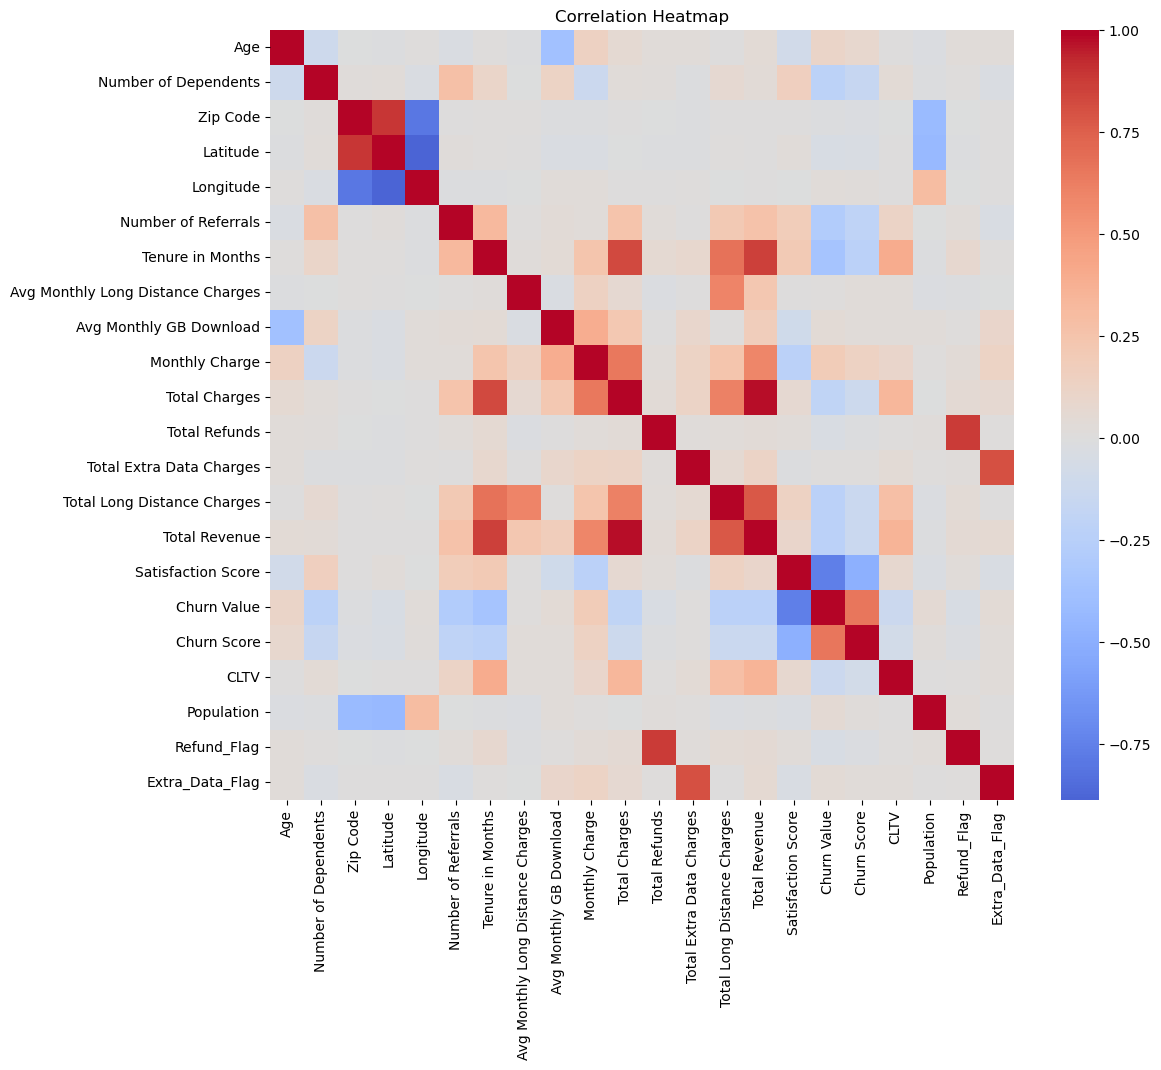

In [ ]:
plt.figure(figsize=(12,10))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap")
plt.show()

The correlation results confirm several patterns we already observed during the churn-by-feature analysis, but they also reveal which numeric variables actually matter and which ones do not meaningfully relate to churn.

**Strongest relationship:**

Satisfaction Score (–0.75)
This is by far the strongest correlation in the dataset.
- Lower satisfaction is strongly associated with higher churn.
- This is expected because dissatisfaction is a direct emotional/behavioural signal.

**Moderate relationship:**

Tenure in Months (–0.35)
- Longer-tenure customers churn much less.
- Matches the pattern you saw: early-lifecycle customers are high-risk.

Number of Referrals (–0.29)
- Customers who refer friends are less likely to churn.
- Reinforces the insight that advocacy = loyalty.

**Weak-to-moderate:**

Total Long Distance Charges (–0.22); Total Revenue (–0.22); Number of Dependents (–0.22); Total Charges (–0.19); CLTV (–0.13)

These are all tenure-linked variables — customers who stay longer accumulate higher revenue and charges, thus they churn less.

# Multi-Feature & Interaction Analysis

Up to this point, the EDA has focused on **univariate** and **bivariate** exploration, helping us understand how each individual feature behaves and how it relates to churn on its own. This provided a solid foundation and highlighted the main churn drivers at a high level.

However, churn behaviour is rarely driven by one variable in isolation.

### Customers churn because of *combinations* of factors, such as:
- Contract type **and** payment method  
- Monthly charges **and** tenure  
- Internet type **and** service add-ons  
- Number of subscribed services **and** customer profile  

To uncover these deeper patterns, we now move into **multi-feature and interaction analysis**.

This step helps us understand:
- How multiple variables interact to influence churn  
- Which customer segments are most at risk  
- Whether certain risk factors reinforce each other  
- Which feature combinations may be useful for modelling and retention strategy  

### In this section, we will explore:
- Churn across key feature combinations (e.g., Contract × Payment Method)  
- Heatmaps showing churn variation across two dimensions  
- Scatterplots to visualise numeric interactions  
- Bundle/service-mix effects on retention  
- Relationship patterns not visible in single-variable analysis  

### Selected Feature Interactions

We analyse the following interactions:  
- **Contract × Payment Method**  
- **Contract × Online Security**  
- **Tenure × Contract**  
- **Tenure × Monthly Charges**  
- **Add-on Bundling (Number of Services)**  
- **CLTV & Revenue vs Churn**

These were chosen because they were the **strongest churn predictors individually** and make **business sense when combined**, revealing meaningful behavioural patterns that weaker variables (e.g., gender, city, streaming services) cannot provide.

### 1. Contract × Payment Method

In [87]:
contract_payment_churn = (
    pd.crosstab(
        df["Contract"],
        df["Payment Method"],
        df["Churn Value"],
        aggfunc="mean"
    ).round(3)
)

contract_payment_churn

Payment Method,Bank Withdrawal,Credit Card,Mailed Check
Contract,,,
Month-to-Month,0.533,0.290,0.556
One Year,0.128,0.077,0.146
Two Year,0.037,0.017,0.000


- Month-to-Month customers show very high churn regardless of payment method
  - Bank Withdrawal: 53.3%
  - Credit Card: 29.0%
  - Mailed Check: 55.6%
- One-Year contracts show much lower churn across all payment methods
  - Churn stays between 7–15%
- Two-Year contracts have near-zero churn, especially for Credit Card and Mailed Check.

**Main Insight:**

Payment method only matters for Month-to-Month customers.
Among long-term contracts, churn remains extremely low regardless of how customers pay.

### 2. Contract × Online Security

In [88]:
# Churn rate by Contract x Online Security
contract_security_churn = (
    pd.crosstab(
        df["Contract"],
        df["Online Security"],
        df["Churn Value"],
        aggfunc="mean"
    ).round(3)
)

contract_security_churn

Online Security,No,Yes
Contract,,
Month-to-Month,0.489,0.322
One Year,0.108,0.105
Two Year,0.024,0.028


- For Month-to-Month customers, churn drops substantially if they have online security:
  - No Security: 48.9%
  - With Security: 32.2%
- For One-Year contracts, churn is already low (~10%) and security has minimal effect.
- For Two-Year contracts, churn is almost zero regardless of security.

**Main Insight:**

Online Security only protects customers when they are on Month-to-Month contracts.

### 3. Tenure Group × Contract

In [89]:
tenure_contract_pivot = pd.crosstab(
    df["Tenure Group"],
    df["Contract"],
    df["Churn Value"],
    aggfunc="mean"
).round(2)

tenure_contract_pivot

Contract,Month-to-Month,One Year,Two Year
Tenure Group,,,
0–6,0.57,0.08,0.00
7–12,0.45,0.10,0.00
13–24,0.41,0.07,0.00
25–48,0.37,0.10,0.02
49–72,0.30,0.13,0.03


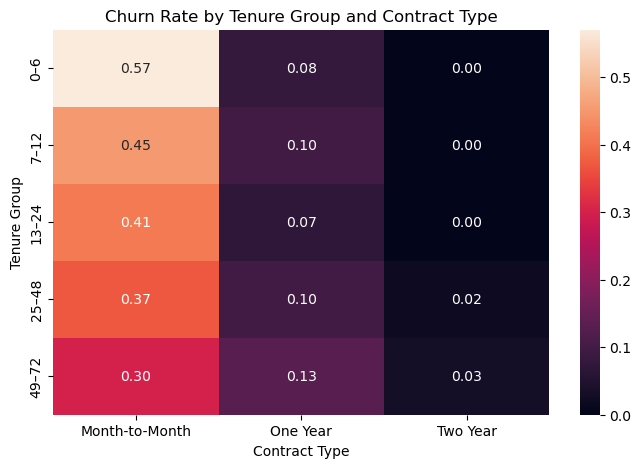

In [90]:
plt.figure(figsize=(8, 5))
sns.heatmap(tenure_contract_pivot, annot=True, fmt=".2f")
plt.title("Churn Rate by Tenure Group and Contract Type")
plt.ylabel("Tenure Group")
plt.xlabel("Contract Type")
plt.show()


Across all tenure groups, churn for Month-to-Month customers remains high:

- 0–6 months: 57%
- 7–12 months: 45%
- 13–24 months: 41%
- 25–48 months: 37%
- 49–72 months: 30%

Meanwhile:

- One-Year contracts: ~7–13% churn
- Two-Year contracts: 0–3% churn consistently

**Main Insight:**

Contract type dominates churn behaviour more strongly than tenure.

### 4. Tenure vs Monthly Charge

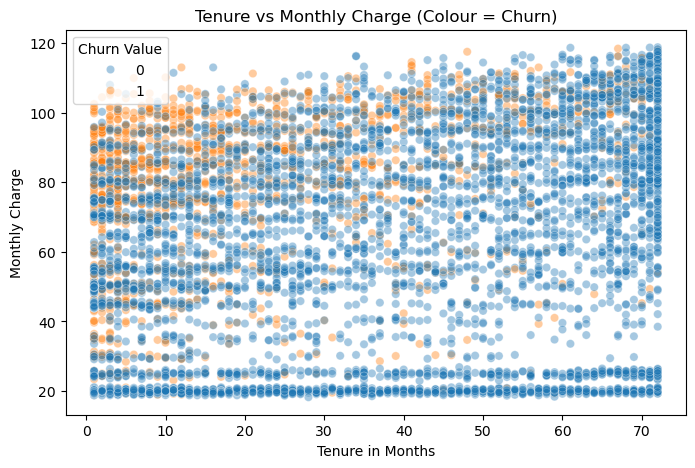

In [91]:
plt.figure(figsize=(8, 5))
sns.scatterplot(
    data=df,
    x="Tenure in Months",
    y="Monthly Charge",
    hue="Churn Value",
    alpha=0.4
)
plt.title("Tenure vs Monthly Charge (Colour = Churn)")
plt.xlabel("Tenure in Months")
plt.ylabel("Monthly Charge")
plt.legend(title="Churn Value", loc="best")
plt.show()

- Churners cluster heavily at:
  - Low tenure (< 12 months)
  - High monthly charges (> $80)
- Non-churners are spread across the entire plot, but are denser in:
  - Long tenure
  - Low to moderate charges

**Main Insight:**

High monthly charges early in the customer lifecycle strongly predict churn.

### 5. Add-on Bundling / Cross-Sell Effect

5.1 Create “NumServices” = number of services/add-ons per customer

In [92]:
service_cols = [
    "Online Security",
    "Online Backup",
    "Device Protection Plan",
    "Premium Tech Support",
    "Streaming TV",
    "Streaming Movies",
    "Streaming Music",
]

df["NumServices"] = df[service_cols].eq("Yes").sum(axis=1)
df["NumServices"].value_counts().sort_index()

NumServices
0    2173
1     827
2     852
3     901
4     851
5     688
6     494
7     257
Name: count, dtype: int64

5.2 Churn by number of services

In [93]:
churn_by_num_services = churn_rate_by("NumServices")
churn_by_num_services

,Churn Rate
NumServices,
1,0.431681
2,0.376761
3,0.310766
4,0.296122
5,0.213663
0,0.202025
6,0.121457
7,0.050584


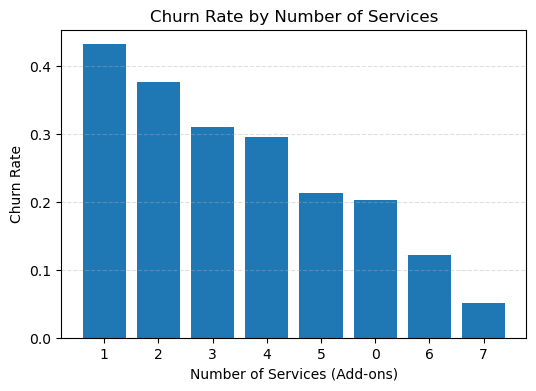

In [94]:
plt.figure(figsize=(6, 4))
plt.bar(
    churn_by_num_services.index.astype(str),
    churn_by_num_services["Churn Rate"]
)
plt.title("Churn Rate by Number of Services")
plt.xlabel("Number of Services (Add-ons)")
plt.ylabel("Churn Rate")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.show()

**Main Insight:**

Customers with more add-on services churn far less, showing a strong and consistent retention effect. Lightly engaged customers (0–1 services) have the highest churn, while fully bundled customers (6–7 services) are extremely loyal. This suggests that cross-selling is one of the most powerful levers to reduce churn, as each additional service increases customer stickiness and reduces the likelihood of switching.

### 6. CLTV & Total Revenue vs Churn

6.1 Average CLTV by churn

In [95]:
cltv_by_churn = df.groupby("Churn Value")["CLTV"].mean().to_frame("Mean CLTV")
cltv_by_churn

,Mean CLTV
Churn Value,
0,4490.921337
1,4149.414660


6.2 Average Total Revenue by churn

In [96]:
revenue_by_churn = df.groupby("Churn Value")["Total Revenue"].mean().to_frame("Mean Total Revenue")
revenue_by_churn

,Mean Total Revenue
Churn Value,
0,3418.374927
1,1971.353569


6.3 CLTV distribution by churn

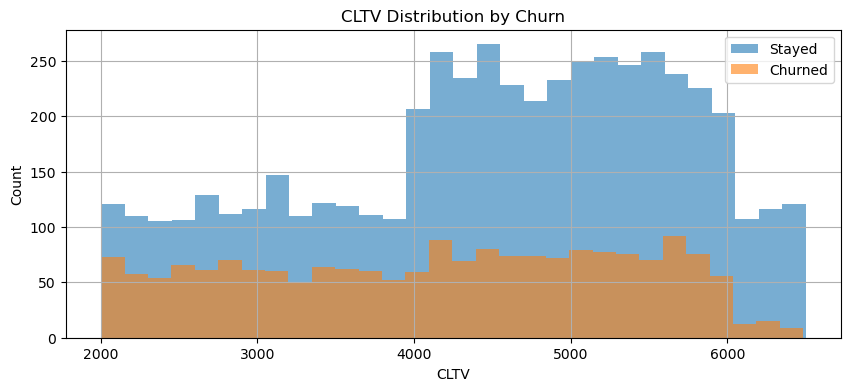

In [97]:
plt.figure(figsize=(10, 4))
df[df["Churn Value"] == 0]["CLTV"].hist(bins=30, alpha=0.6, label="Stayed")
df[df["Churn Value"] == 1]["CLTV"].hist(bins=30, alpha=0.6, label="Churned")
plt.title("CLTV Distribution by Churn")
plt.xlabel("CLTV")
plt.ylabel("Count")
plt.legend()
plt.show()

Customers who churn generate significantly less total revenue over their lifecycle and have slightly lower CLTV compared to those who stay. The gap in total revenue is especially large:

- Stayed customers: ~$3,418
- Churned customers: ~$1,971

This confirms a clear profitability pattern:
High-value, high-revenue customers are far more loyal, while churners tend to be lower-value, shorter-tenure customers.

In other words, revenue and CLTV behave as “stability indicators”, with customers who contribute more over time being much less likely to leave, reflecting strong product fit, longer tenure, and sustained engagement.

## EDA final insight

Our exploratory analysis shows that churn is driven by a combination of contract flexibility, customer tenure, service engagement, and billing/payment behaviours.

High churn groups:
- Month-to-month customers
- Customers using mailed check or bank withdrawal
- Customers without online security or tech support
- Early-tenure customers (0–12 months)
- Customers with high monthly charges
- Customers with few or no add-on services

Low churn groups:
- One-year and two-year contracts
- Customers with high tenure
- Customers using credit card payments
- Customers with 4+ bundled services
- Customers with high CLTV and high total revenue

The multivariate analysis confirms that churn risk is not driven by a single factor but by interactions between flexibility (contract), price (charges), engagement (add-ons), and lifecycle stage (tenure). This provides a strong foundation for feature engineering, modelling, and building churn-risk interventions.